Credit Card Fraud Detection with Visualization


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve
)
import joblib
import warnings
warnings.filterwarnings('ignore')


#  Load Dataset

In [21]:

train_df = pd.read_csv(r"C:\Users\mdhar\Documents\ML project\Credit Card Transactions Fraud Detection Dataset\fraudTrain.csv")
test_df = pd.read_csv(r"C:\Users\mdhar\Documents\ML project\Credit Card Transactions Fraud Detection Dataset\fraudTest.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nColumns:", train_df.columns.tolist())


#  Drop Unnecessary Columns

drop_cols = [
    'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last',
    'street', 'city', 'state', 'zip', 'lat', 'long', 'dob',
    'unix_time', 'trans_num'
]
train_df = train_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')



Train shape: (1296675, 23)
Test shape: (555719, 23)

Columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [22]:

#  Encode Categorical Columns (Safe Encoding)

cat_cols = train_df.select_dtypes(include=['object']).columns

for col in cat_cols:
    le = LabelEncoder()
    le.fit(train_df[col].astype(str))
    
    # Create mapping dictionary for test data
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # Apply to train
    train_df[col] = train_df[col].astype(str).map(mapping)
    
    # For test, unseen labels get -1
    test_df[col] = test_df[col].astype(str).map(lambda s: mapping.get(s, -1))

Data Visualization

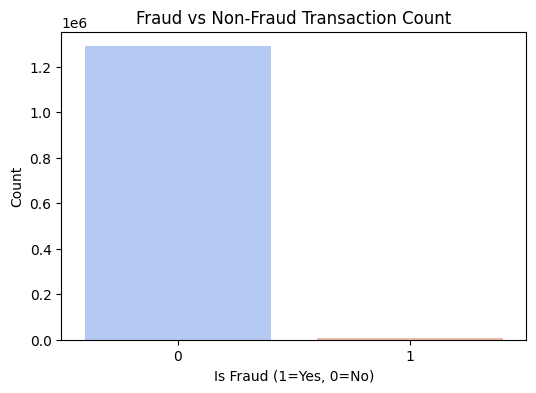

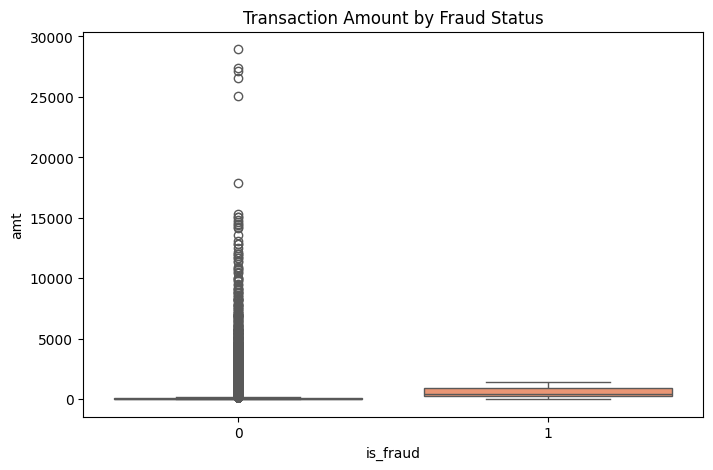

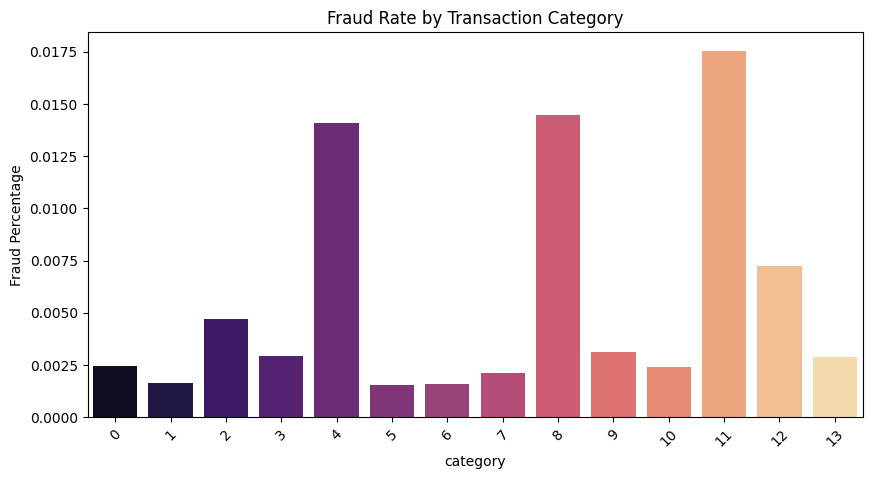

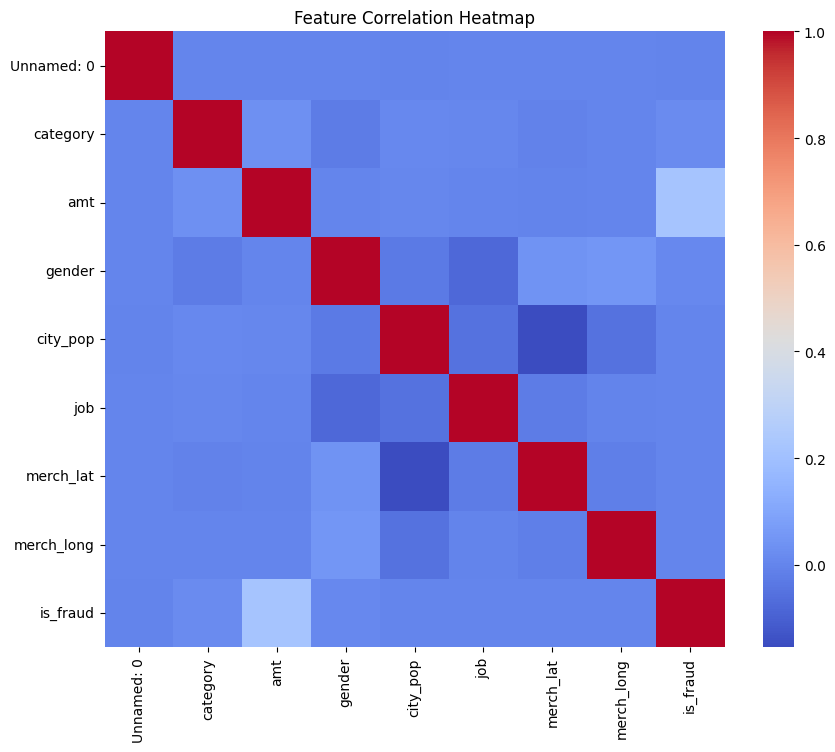

In [23]:
drop_cols = [
    'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last',
    'street', 'city', 'state', 'zip', 'lat', 'long', 'dob',
    'unix_time', 'trans_num'
]
train_df = train_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')


# Encode Categorical Columns (Safe Encoding)

cat_cols = train_df.select_dtypes(include=['object']).columns

for col in cat_cols:
    le = LabelEncoder()
    le.fit(train_df[col].astype(str))
    
    # Create mapping dictionary for test data
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # Apply to train
    train_df[col] = train_df[col].astype(str).map(mapping)
    
    # For test, unseen labels get -1
    test_df[col] = test_df[col].astype(str).map(lambda s: mapping.get(s, -1))



# Fraud class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=train_df, palette='coolwarm')
plt.title('Fraud vs Non-Fraud Transaction Count')
plt.xlabel('Is Fraud (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

# Transaction amount distribution
plt.figure(figsize=(8,5))
sns.boxplot(x='is_fraud', y='amt', data=train_df, palette='Set2')
plt.title('Transaction Amount by Fraud Status')
plt.show()

# Category-wise fraud percentage
fraud_rate = train_df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette='magma')
plt.title('Fraud Rate by Transaction Category')
plt.ylabel('Fraud Percentage')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


Train/Test Split

In [24]:
X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']

X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']


#  Scale Features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train Random Forest Model


Training Random Forest model...

✅ Accuracy: 0.9849
✅ ROC-AUC Score: 0.9859

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.18      0.83      0.30      2145

    accuracy                           0.98    555719
   macro avg       0.59      0.91      0.65    555719
weighted avg       1.00      0.98      0.99    555719



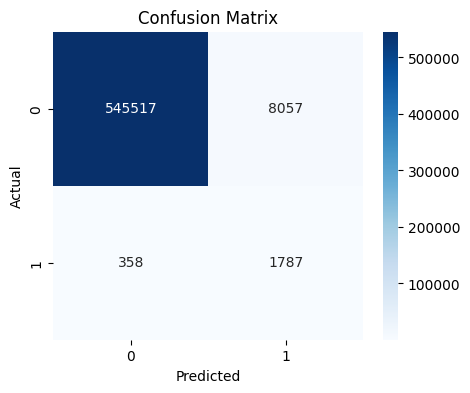

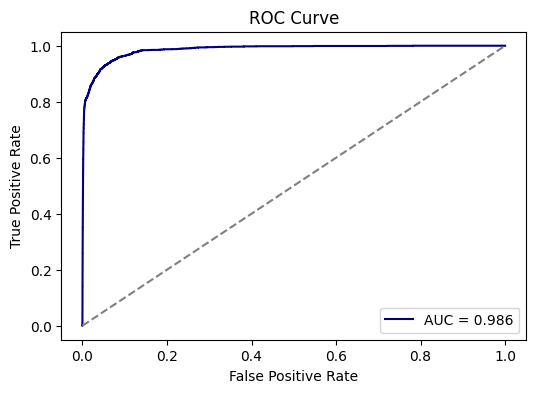

In [ ]:
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    random_state=42,
    class_weight='balanced'
)

print("\nTraining Random Forest model...")
rf.fit(X_train_scaled, y_train)


#  Evaluate Model

y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

print("\n Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(" ROC-AUC Score:", round(roc_auc_score(y_test, y_prob), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}", color='navy')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Feature Importance Visualization

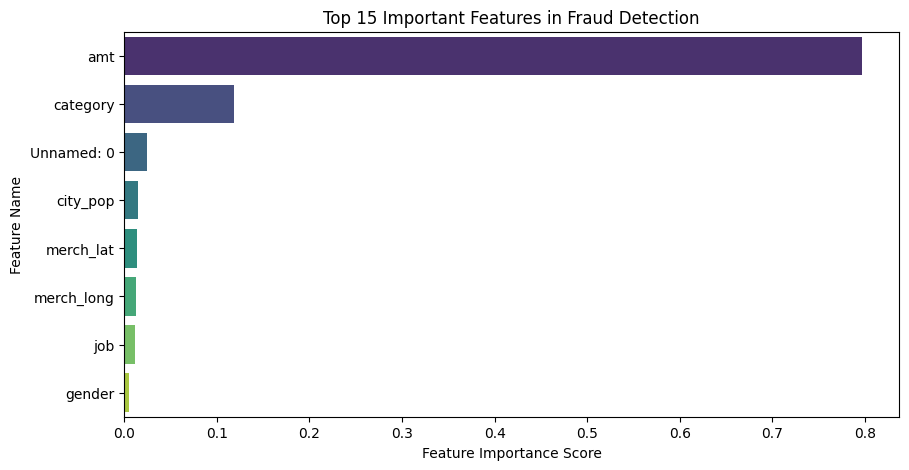

In [26]:
importances = rf.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15], palette='viridis')
plt.title("Top 15 Important Features in Fraud Detection")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.show()

Save Model

In [ ]:
joblib.dump(rf, "fraud_detection_model.pkl")
print("\n Model saved successfully as fraud_detection_model.pkl")


✅ Model saved successfully as fraud_detection_model.pkl
